In [51]:
import numpy as np
import json
import matplotlib.pyplot as plt

net_type = ["spinn","pfnn"][0]
iteration = 1000
time = [120, False][0]
run_number = 0

run = f"{net_type}_{time if time else iteration}{'min' if time else 'iter'}{f"-{run_number}" if run_number else ''}"    

save_folder = [r"results/",r"/mnt/d/phd/SPIQ/plate_hole_quarter/soft/"][1]

run_folder = save_folder + run + "/"


with open(run_folder + "config.json") as f:
    run_config = json.load(f)
# with open(run2_folder + "config.json") as f:
#     spinn_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values

def moving_average(arr, window_size):
    window = np.ones(window_size)/window_size
    return np.apply_along_axis(lambda x: np.convolve(x, window, mode='valid'), 0, arr)

def moving_min(arr, window_size):
    new_arr = np.zeros((arr.shape[0] - window_size + 1, arr.shape[1]))
    for n_metric in range(arr.shape[1]):
        for i in range(new_arr.shape[0]):
            new_arr[i, n_metric] = np.min(arr[i:i+window_size, n_metric])
    return new_arr
    
loss_history = np.loadtxt(run_folder + "loss_history.dat")
# loss_history_mean = moving_average(loss_history, 20)
# loss_history_min = moving_min(loss_history, 20)

residuals = loss_history[:, -1]
PDE_loss = np.mean(loss_history[:, 1:3], axis=1)
Mat_loss = np.mean(loss_history[:, 3:5], axis=1) 
steps_loaded = loss_history[:, 0]

metrics = [residuals, PDE_loss, Mat_loss]
metrics_names = ["Residuals", "PDE Loss", "Material Loss"]

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(loss_history[:, 0], loss_history[:, -1], loss_history_min[:, 0], loss_history_min[:, -1], loss_history_mean[:, 0], loss_history_mean[:, -1])
# ax.set_yscale('log')

FileNotFoundError: /mnt/d/phd/SPIQ/plate_hole_quarter/soft/spinn_120min/loss_history.dat not found.

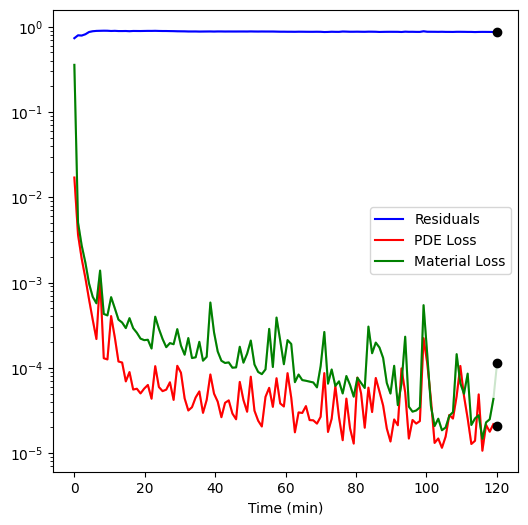

In [41]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
metrics_idx = [0,1, 2]#, 3]

t_elapsed = run_config["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_elapsed/steps_loaded[-1]
    if time_unit == "min":
        steps = steps/60
else:
    steps = steps_loaded

def init_metrics(ax, metrics_idx=metrics_idx):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for idx in metrics_idx:
        ax.plot(steps, metrics[idx], alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
        lines.append(ax.plot([], [], zorder=3, color=['b', 'r', 'g', 'y'][idx], label=metrics_names[idx])[0])
        scatters.append(ax.scatter([], [], c='k', zorder=4))


    # line_pinn, = ax.plot([], [], color='b', zorder=3)
    # ax.plot(steps, residuals, color='b', alpha=0.2)
    # scatter_pinn = ax.scatter([], [], c='k', zorder=4)
    ax.legend()
    # ax.set_ylabel("Mean residual")
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=metrics_idx):

    for line, scatter, metric_idx in zip(lines, scatters, metrics_idx):
        line.set_data(steps[:iterations], metrics[metric_idx][:iterations])
        scatter.set_offsets([steps[iterations], metrics[metric_idx][iterations]])

    return lines, scatters

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
lines, scatters = init_metrics(ax)
update_metrics(-1, lines, scatters)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

In [42]:

logged_field = run_config["logged_fields"]
field_names = list(logged_field.values())
fields_id = [0,1,2,3,4][:] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}


fields = [None]*5
for field_id in fields_id:
    field_name = logged_field[str(field_id)]
    _, V_pinn = read_data_file(run_folder + f"{field_name}_history.dat")
    fields[field_id] = np.array(V_pinn)

/tmp/ipykernel_9845/1120865666.py:65: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)


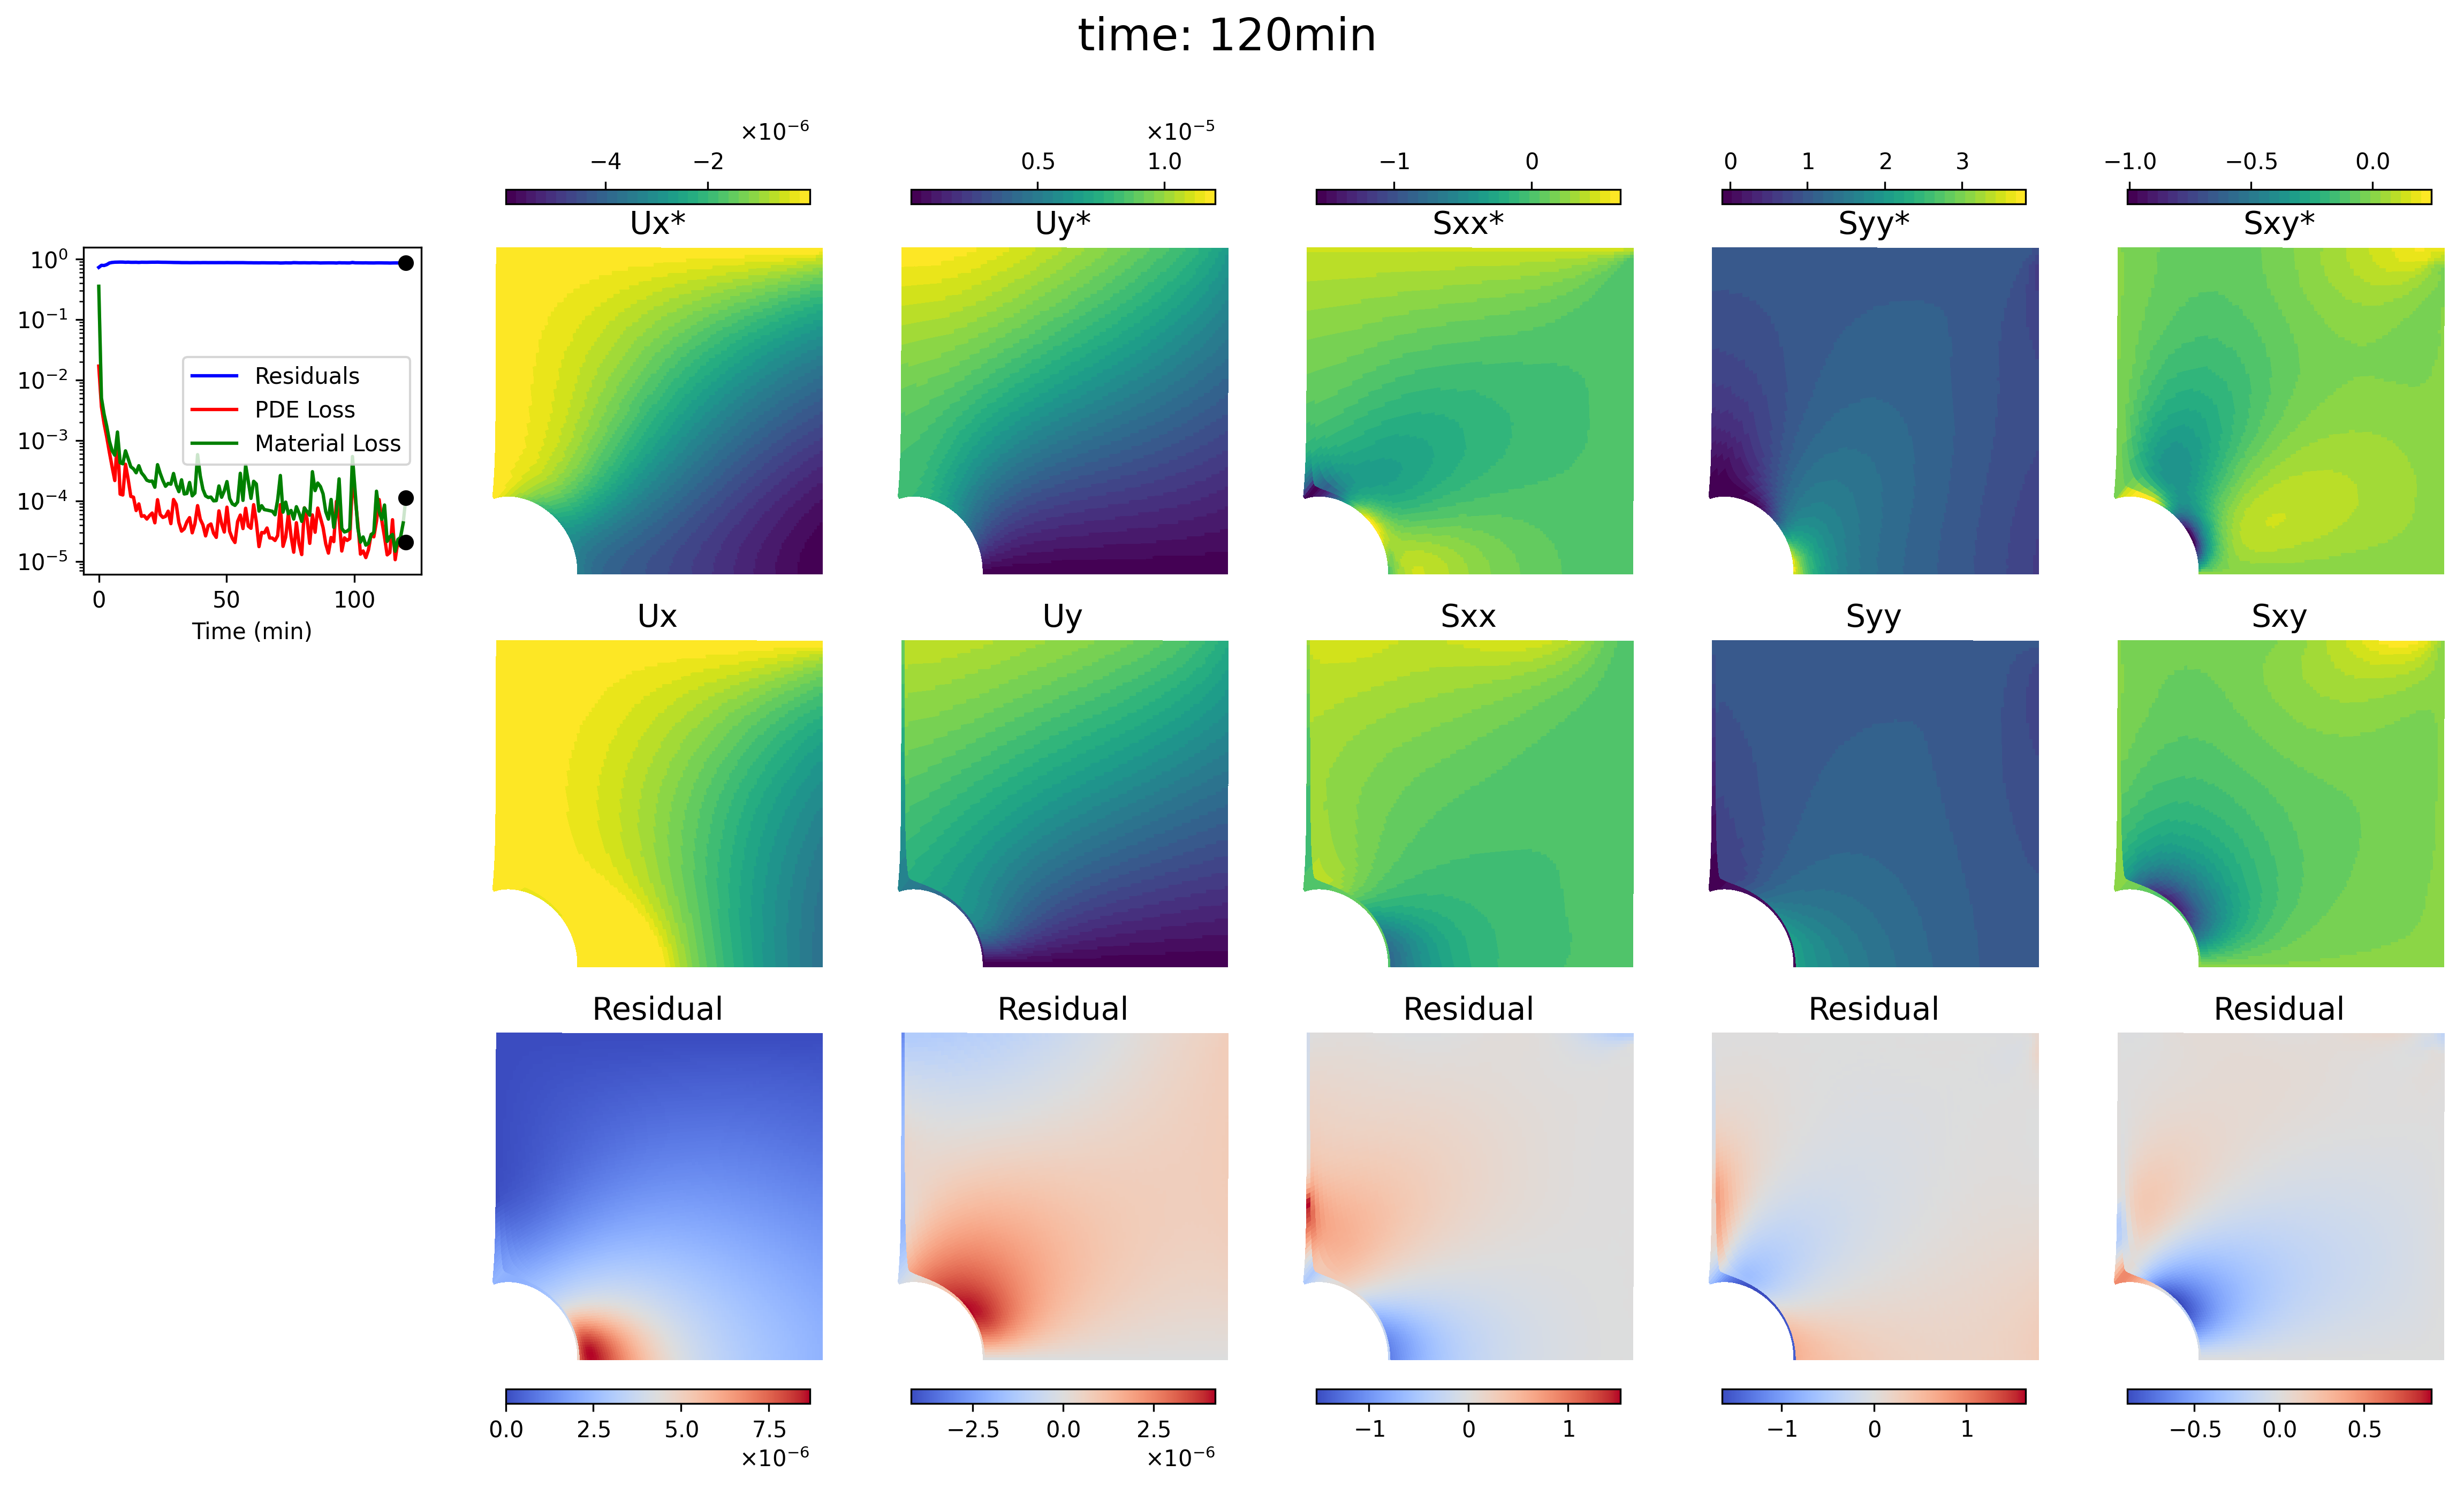

In [50]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms


fields_id = [0,1,2,3,4][:] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
n_fields = len(fields_id)

x_max = 2.0
y_max = 2.0

# Load FEM reference solution
n_mesh_x = 100
n_mesh_y = 100
data = np.loadtxt(f"fem_solution_{n_mesh_x}x{n_mesh_y}.dat")
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

func = lambda x: np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

# Load geometry mapping
from scipy.ndimage import map_coordinates
nx=100
ny=100

Xp = np.loadtxt(f"plate_hole_quarter_{nx}x{ny}.txt")


# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def geometry_mapping(x,y):
    x_pos = x/x_max*(nx-1)
    y_pos = y/y_max*(ny-1)

    x_mapped = map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return x_mapped, y_mapped


cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):

    # X, Y = compute_edges_from_nodes(X, Y)
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)

    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(i, fields, field_id, Xmesh, Ymesh, func, ax, plot_exact=False):
    field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
    field_exact = func(np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_norm = colors.Normalize(vmin=field_exact.min(), vmax=field_exact.max())
    if plot_exact:
        im = pcolor_plot(ax, Xmesh, Ymesh, field_exact, f"{field_names[field_id]}*", norm=field_norm)
    else:
        im = pcolor_plot(ax, Xmesh, Ymesh, field, field_names[field_id], norm=field_norm)

    return im

def plot_field_residual(i, fields, field_id, Xmesh, Ymesh, func, ax, diff_norm, ngrid=100):
    field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_diff = np.array(fields[field_id][i]).reshape(Xmesh.shape)-field_exact
    im = pcolor_plot(ax, Xmesh, Ymesh, field_diff, "Residual", colormap="coolwarm", norm=diff_norm)
    return im

def set_normdiff(i, fields, fields_id, field_id, func, Xmesh, Ymesh, ngrid=100,all_fields=False):
    fields_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))

    cmaxs = []  
    cmins = []
    
    fields_to_consider = fields_id if all_fields else [field_id]

    for field_id in fields_to_consider:
        diff = np.array(fields[field_id][i]).reshape(-1,ngrid,ngrid)-fields_exact[:,field_id].reshape(ngrid,ngrid)
        abs_diff = np.abs(diff)
        cmax = abs_diff.max() if diff.max() > 0 else 0
        cmin = -abs_diff.max() if diff.min() < 0 else 0
        cmaxs.append(cmax)
        cmins.append(cmin) 
    normdiff = colors.Normalize(vmin=-1, vmax=1)
    normdiff.vmin = min(cmins)
    normdiff.vmax = max(cmaxs)
    return normdiff

def make_formatter():
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    return formatter

iter = -1
ngrid = 100
field_id = 0

Xgrid, Ygrid = np.meshgrid(np.linspace(0, x_max, ngrid), np.linspace(0, y_max, ngrid), indexing='ij')

Xmesh, Ymesh = geometry_mapping(Xgrid, Ygrid)
n_types = 3


width_ratios = [1] + [1] * n_fields
# Create the figure and subplots with the specified width ratios
fig, ax = plt.subplots(n_types, 1 + n_fields, figsize=(4 + n_fields * 3, 3 * n_types), dpi=50 + 50 * n_fields, gridspec_kw={'width_ratios': width_ratios})

ax[1][0].axis("off")
ax[2][0].axis("off")
lines, scatters = init_metrics(ax[0][0], metrics_idx=metrics_idx)
lines, scatters = update_metrics(iter, lines, scatters, metrics_idx=metrics_idx)
# pos = ax[0][0].get_position()
# ax[0][0].set_position([pos.x0, pos.y0+0.4*pos.height, pos.width, pos.height*0.6])
ims_field = []
ims_ref = []
ims_res = []
cbdiffs = []
for i, field_id in enumerate(fields_id):
    ims_ref.append(plot_field(iter, fields, field_id, Xmesh, Ymesh, func, ax[0][i+1],plot_exact=True))
    ims_field.append(plot_field(iter, fields, field_id, Xmesh, Ymesh, func, ax[1][i+1],plot_exact=False))

    pos = ax[0][i+1].get_position()
    cax_pos = mtransforms.Bbox.from_bounds(pos.x0+pos.width*0.05, pos.y1 + 0.03, pos.width*0.9, 0.01)
    cax = fig.add_axes(cax_pos)
    cbfield = fig.colorbar(ims_field[i], cax=cax, orientation='horizontal', format= make_formatter())
    cbfield.ax.xaxis.set_ticks_position('top')

    normdiff = set_normdiff(iter, fields, fields_id, field_id, func, Xmesh, Ymesh, ngrid)
    ims_res.append(plot_field_residual(iter, fields, field_id, Xmesh, Ymesh, func, ax[2][i+1], normdiff))
    
    pos = ax[2][i+1].get_position()
    cax_pos = mtransforms.Bbox.from_bounds(pos.x0+pos.width*0.05, pos.y0 - 0.03, pos.width*0.9, 0.01)
    cax = fig.add_axes(cax_pos)
    cbdiffs.append(fig.colorbar(ims_res[i], cax=cax, orientation='horizontal', format= make_formatter()))

# cax = fig.add_axes([0.91, 0.115, 0.009, 0.34])
# cbdiff = fig.colorbar(ims_res[0], cax=cax)

fig.suptitle(f"{step_type}: {steps[iter]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=20, y=1.04)
plt.tight_layout
plt.show()

In [36]:
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import chain

def animate(i, ims_field, ims_ref, ims_res, cbdiffs, lines, scatters):

    step = int(steps[i])

    fig.suptitle(f"{step_type}: {steps[i]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=20, y=1.04)
    lines, scatters = update_metrics(i, lines, scatters)
    
    for im_field, im_res, cbdiff, field_id in zip(ims_field, ims_res, cbdiffs, fields_id):
        field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
        field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
        field_diff = field-field_exact

        im_field.set_array(field)
        # im_ref.set_array(field_exact)
        im_res.set_array(field_diff)
        
        abs_diff = np.abs(field_diff)
        normdiff = colors.Normalize(vmin=-abs_diff.max(), vmax=abs_diff.max())
        im_res.set_norm(normdiff)
        cbdiff.update_normal(im_res)
        cbdiff.formatter = make_formatter()
        cbdiff.update_ticks()

    return ims_field, ims_ref, ims_res, cbdiffs, lines, scatters

def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps)*i/len(sub_factors)) for i in range(1, len(sub_factors)+1)]
    frame_steps_lists = []
    for i, step_size in enumerate(sub_factors):
        start = section_ends[i-1] if i > 0 else 0
        end = section_ends[i]
        frame_steps_lists.append(range(start, end, step_size))
    frame_steps = chain.from_iterable(frame_steps_lists)
    return frame_steps


all_steps = list(range(len(steps)))
sub_factors = [1] #list(range(1,4)) + [4]*5 #slower at the beginning
frame_steps = list(subsample_steps(all_steps, sub_factors))

anim = animation.FuncAnimation(fig, animate, fargs=(ims_field, ims_ref, ims_res, cbdiffs, lines, scatters), frames=frame_steps, interval=100, repeat=False)

fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

Video duration:  14.5 s


In [22]:
# video_name = f"./videos/{"-".join([field_names[field_id] for field_id in fields_id])}_lambda-{lmbd_start}_mu-{mu_start}_nDIC-{nDIC}_{net_type}_{iteration}iter_{step_type}"
video_name = f"{"-".join([field_names[field_id] for field_id in fields_id])}_{step_type}"
video_path = f"{run_folder}{video_name}"
anim.save(f"{video_path}.mp4", writer='ffmpeg', fps=10)
# anim.save(f"{video_name}.gif", writer='imagemagick', fps=10)
print(f"Video saved at {video_path}.mp4")

Video saved at /mnt/d/phd/SPIQ/plate_hole_quarter/forward/spinn_10min-2/Ux-Uy-Sxx-Syy-Sxy_time.mp4


1.0062844792084542

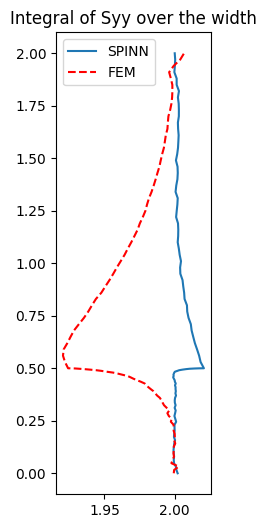

In [44]:
Syy = fields[3]
Syy = np.array(Syy[-1]).reshape(Xmesh.shape)
Syy_exact = func(np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1))))[:,3].reshape(Xmesh.shape)

Integral_x = np.trapz(Syy, Xmesh, axis=0)
Integral_x_exact = np.trapz(Syy_exact, Xmesh, axis=0)

fig = plt.figure(figsize=(2,6))
plt.plot(Integral_x,Ymesh[0,:], label="SPINN")
plt.plot(Integral_x_exact,Ymesh[0,:], linestyle="--", color="r", label="FEM")
# plt.plot((Integral_x-1.0)**2)
plt.legend()
plt.title("Integral of Syy over the width")

np.mean(np.square(1.0 - Integral_x))

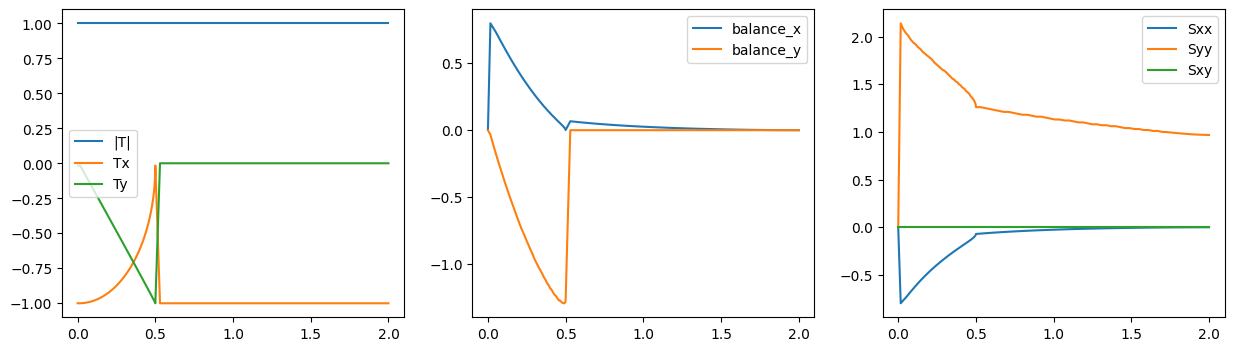

In [49]:
import jax
import jax.numpy as jnp

R=0.5

def coordMap(x, padding=1e-6, nx=nx, ny=ny, X_map_points=X_map_points, Y_map_points=Y_map_points):
    x_pos = x[0]/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

def calcNormal(x):
    n = jnp.array([-1, 0])
    n_mapped = tensMap(n, x)
    return n_mapped/jnp.linalg.norm(n_mapped)

# fields_bc = [F_bcs[:,i].reshape(len(x_bcs), len(y_bcs)).T for i in range(6)]
x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

normal_mapped = jax.vmap(calcNormal)(X_left)
Tx_j, Ty_j = normal_mapped[:, 0], normal_mapped[:, 1]

Tx, Ty = Tx_j, Ty_j

# Tx = [-X_left_mapped[i,0]/R if X_left_mapped[i,1] <= R+1e-6 else -1 for i in range(ngrid)]
# Ty = [-X_left_mapped[i,1]/R if X_left_mapped[i,1] <= R+1e-6 else 0 for i in range(ngrid)] 

Sxx_left = fields[2][-1].reshape(Xmesh.shape)[:,0]
Syy_left = fields[3][-1].reshape(Xmesh.shape)[:,0]
Sxy_left = fields[4][-1].reshape(Xmesh.shape)[:,0]
# Sbc_left = fields_bc[5][:,0]

balance_x = Sxx_left*Tx + Sxy_left*Ty 
balance_y = Sxy_left*Tx + Syy_left*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(X_left_mapped[:,1],np.array(Tx)**2 + np.array(Ty)**2, label='|T|')
axs[0].plot(X_left_mapped[:,1],Tx, label='Tx')
axs[0].plot(X_left_mapped[:,1],Ty, label='Ty')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y[:], label='balance_y')
axs[1].legend()
# axs[1].set_ylim([-0.05, 0.05])

axs[2].plot(X_left_mapped[:,1],Sxx_left, label='Sxx')
axs[2].plot(X_left_mapped[:,1],Syy_left, label='Syy')
axs[2].plot(X_left_mapped[:,1],Sxy_left, label='Sxy')
# axs[2].plot(X_left_mapped[:,1],Sbc_left, label='Sbc')
axs[2].legend()

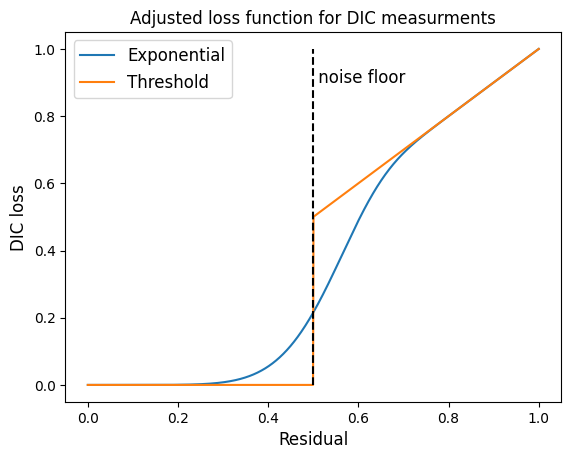

In [29]:
#exponential decay
max_range = 1
noise_floor = max_range/2
dist = np.linspace(0, max_range, 1000)

def exponential_loss(dist, noise_floor):
    return dist*(1-np.exp(-(dist/(1.1*noise_floor))**6))
def threshold_loss(dist, noise_floor):
    return np.where(np.abs(dist)<noise_floor, 0, dist)
# plt.figure(size=(8,6))
plt.plot(dist, exponential_loss(dist, noise_floor), label="Exponential")
plt.plot(dist, threshold_loss(dist, noise_floor), label="Threshold")
# plt.plot(dist, dist, 'k--')
plt.vlines(noise_floor, 0, max_range, linestyles='--',colors='k')
plt.text(noise_floor, max_range*0.9, f" noise floor", color='k', fontsize=12)
plt.title("Adjusted loss function for DIC measurments")
plt.xlabel("Residual", fontsize=12)
plt.ylabel("DIC loss", fontsize=12)
plt.legend(fontsize=12)
